# Content-Based Recommendation System

This notebook develops a **content-based recommendation system** using **cosine similarity**. The model leverages product metadata and customer purchase history to recommend similar products based on customer preferences.

Key aspects covered in this notebook:
- Feature extraction from **articles.csv** for building content profiles.
- Implementation of cosine similarity to measure product relevance.
- Generation of personalized recommendations for customers based on past purchases.

This approach personalizes the shopping experience by identifying products that align with each customer’s preferences and purchase history.


In [3]:
!pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


In [7]:
!pip install tensorflow


   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
    --------------------------------------- 5.2/390.3 MB 26.5 MB/s eta 0:00:15
   - -------------------------------------- 11.8/390.3 MB 28.3 MB/s eta 0:00:14
   - -------------------------------------- 17.6/390.3 MB 27.7 MB/s eta 0:00:14
   -- ------------------------------------- 22.0/390.3 MB 25.8 MB/s eta 0:00:15
   -- ------------------------------------- 27.3/390.3 MB 25.8 MB/s eta 0:00:15
   --- ------------------------------------ 33.8/390.3 MB 26.5 MB/s eta 0:00:14
   ---- ----------------------------------- 39.1/390.3 MB 26.1 MB/s eta 0:00:14
   ---- ----------------------------------- 44.8/390.3 MB 26.2 MB/s eta 0:00:14
   ---- ----------------------------------- 48.5/390.3 MB 25.1 MB/s eta 0:00:14
   ----- ---------------------------------- 53.7/390.3 MB 25.0 MB/s eta 0:00:14
   ------ --------------------------------- 59.2/390.3 MB 25.2 MB/s eta 0:00:14
   ------ --------------------------------- 64.7/3

In [1]:
# Importin Data manipulation libraries
import pandas as pd
import numpy as np

# Importing Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Image processing
import cv2

# Mathematical functions
import math

# Machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split

# Deep learning
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
transactions = pd.read_csv("transactions_processed.csv")
transactions = transactions.dropna()

In [5]:
transactions['article_id'] = transactions['article_id'].astype(int)
# Count how often the different articles were bought
article_counts = transactions['article_id'].value_counts()

# Display the 10 most frequently bought products
top_10_articles = article_counts.head(10)

# Print the results
print("Top 10 most frequently bought products:")
print(top_10_articles)

Top 10 most frequently bought products:
article_id
706016001    42672
706016002    30862
372860001    29337
610776002    25234
759871002    23799
372860002    22472
464297007    21782
399223001    19604
720125001    18975
610776001    18777
Name: count, dtype: int64


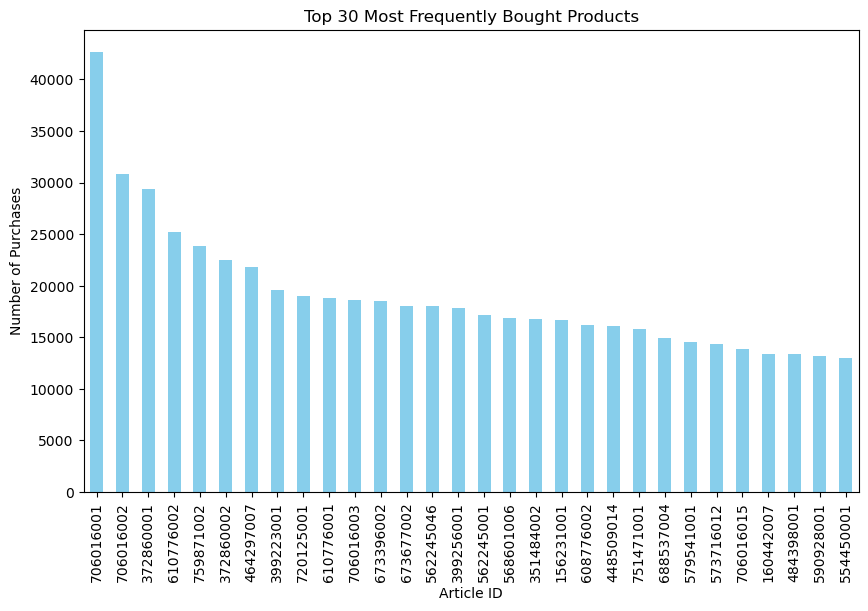

In [7]:
import matplotlib.pyplot as plt

# Count how often the different articles were bought
article_counts = transactions['article_id'].value_counts()

# Select the top 30 most frequently bought products
top_30_articles = article_counts.head(30)

# Plot the most frequently bought products as a bar plot
top_30_articles.plot(kind="bar", figsize=(10, 6), color='skyblue')

# Add labels and title
plt.xlabel('Article ID')
plt.ylabel('Number of Purchases')
plt.title('Top 30 Most Frequently Bought Products')

# Show the plot
plt.show()

Error loading image for Article 610776002: [Errno 2] No such file or directory: 'C:\\Users\\patel\\Fashion_Recommendation\\images\\0610776002.jpg'
Error loading image for Article 610776001: [Errno 2] No such file or directory: 'C:\\Users\\patel\\Fashion_Recommendation\\images\\0610776001.jpg'


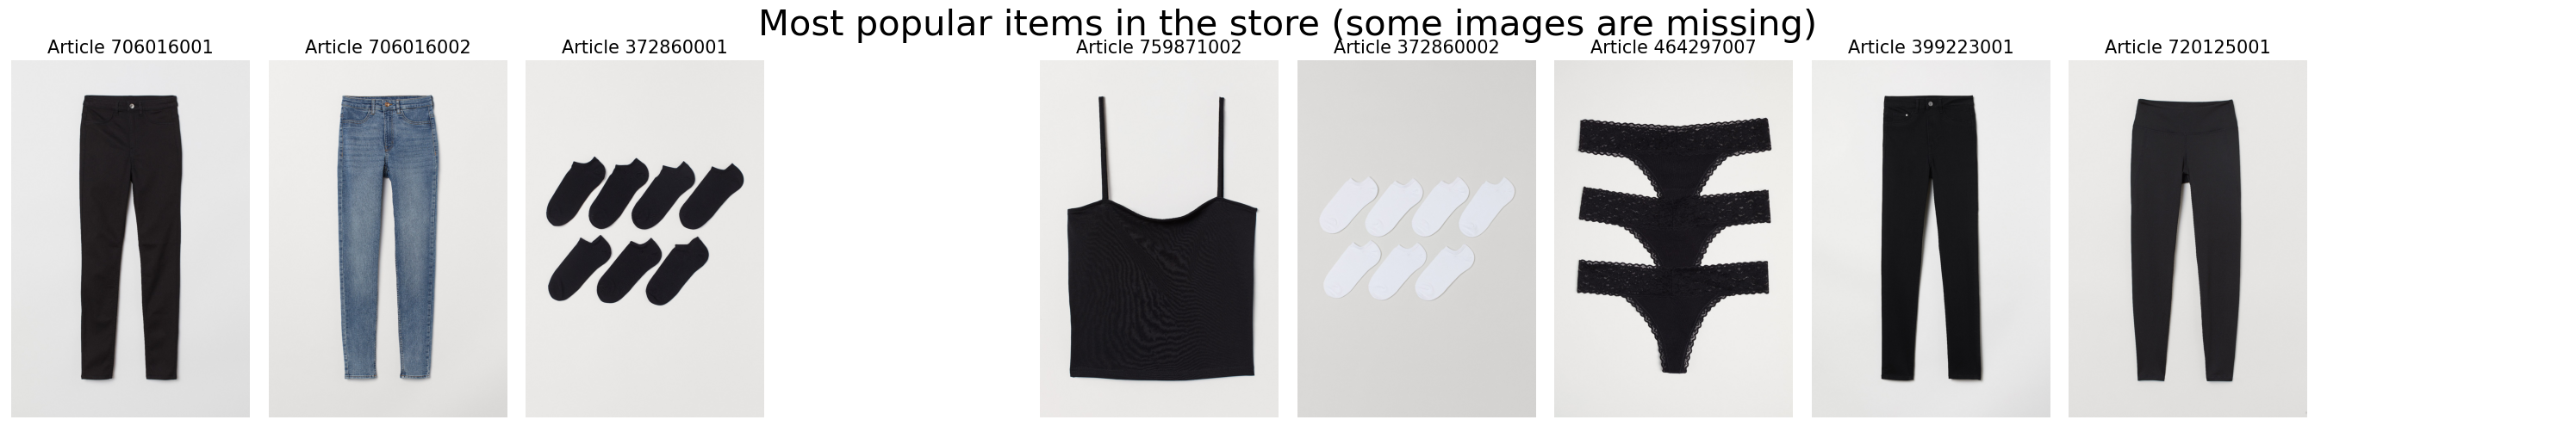

In [9]:
popular_products = transactions['article_id'].value_counts()
popular_items = popular_products.head(10).index  # Assuming 'popular_products' is defined earlier in your code
fig = plt.figure(figsize=(30, 5))

plt.suptitle('Most popular items in the store (some images are missing)', size=30)
plt.axis('off')

for item, i in zip(popular_items, range(1, len(popular_items) + 1)):
    try:
        article_id = str(item).zfill(5)  # Ensure consistent length with leading zeros
        path = os.path.join("images/", f"0{article_id}.jpg")
        image = plt.imread(path)
        
        plt.subplot(1, len(popular_items), i)
        plt.title(f'Article {item}', size=15)
        plt.axis('off')
        plt.imshow(image)
    except Exception as e:
        print(f"Error loading image for Article {item}: {e}")

plt.tight_layout()
plt.show()

In [224]:
import os
# Load the articles data
articles = pd.read_csv("articles_processed.csv")
articles = articles.head(25000)
# Function to check if image exists for an article
def image_exists(row):
    article_id = str(row['article_id']).zfill(5)
    path = os.path.join("images", f"0{article_id}.jpg")
    return os.path.isfile(path)

# Create a new column 'image_exists' based on the function
articles['image_exists'] = articles.apply(image_exists, axis=1)

# Filter out articles with missing images
articles_with_images = articles[articles['image_exists'] == 1]

# Optionally, drop the 'image_exists' column if it's no longer needed
articles = articles.drop('image_exists', axis=1)

# Display the updated DataFrame
articles.head(20)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,purchase_count
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,7535.0
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,5666.0
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,177.0
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",982.0
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",482.0
5,110065011,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,12,Light Beige,...,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",1018.0
6,111565001,111565,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo...",4189.0
7,111565003,111565,20 den 1p Stockings,302,Socks,Socks & Tights,1010016,Solid,13,Beige,...,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo...",41.0
8,111586001,111586,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,...,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Tights with built-in support to lift the botto...,10287.0
9,111593001,111593,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny tights that shape the tummy, thighs...",10171.0


In [13]:
articles.shape

(25000, 26)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a TF-IDF Vectorizer Object. Remove all English stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Replace NaN with an empty string
articles['detail_desc'] = articles['detail_desc'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(articles['detail_desc'])

# Output the shape of tfidf_matrix
print(tfidf_matrix.shape)

# Array mapping from feature integer indices to feature name.
feature_names = tfidf.get_feature_names_out()
print(feature_names[100:110])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

(25000, 1909)
['17x34x36' '18' '180' '18m' '18x23' '18x24' '19' '19x30x39' '19x38x44'
 '19x42']


In [16]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [19]:
#Construct a reverse map of indices
indices = pd.Series(articles.index, index=articles['article_id']).drop_duplicates()

In [21]:
def get_recommendations(article_id, cosine_sim=cosine_sim, top_n=10):
    # Check if the article ID exists in the mapping
    if article_id not in indices:
        print(f"Article ID {article_id} not found.")
        return []

    # Get the index of the article that matches the ID
    idx = indices[article_id]

    # Get the pairwsie similarity scores of all articles with that article
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top N most similar articles
    sim_scores = sim_scores[1:(top_n + 1)]

    # Get the articles indices
    article_indices = [i[0] for i in sim_scores]

    # Return the top N most similar articles
    return articles['article_id'].iloc[article_indices]

In [23]:
recommendations = get_recommendations(150959011)
print(recommendations)

56       150959013
3807     466891001
3808     466891002
3568     458064001
440      241486015
441      241486016
12336    552788001
449      242354009
3806     466852005
17091    572931001
Name: article_id, dtype: int64


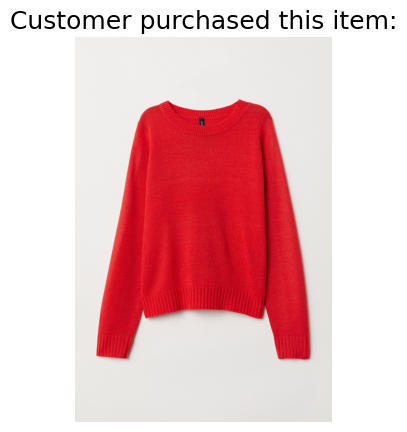

In [49]:
import os
import cv2
import matplotlib.pyplot as plt

BASE_DIR = "images/"
item = 501820043  # Test a random item

# Format file path using os.path.join
image_path = os.path.join(BASE_DIR, f"0{item}.jpg")

# Check if the file exists
if os.path.exists(image_path):
    plt.figure(figsize=(20, 5))
    img = cv2.imread(image_path)[:, :, ::-1]
    plt.title('Customer purchased this item:', size=18)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
else:
    print(f"File not found: {image_path}")

In [51]:
# see results here
recommendations = get_recommendations(item)
print(recommendations)

6052    501820002
6053    501820003
6054    501820004
6055    501820006
6056    501820007
6057    501820008
6058    501820020
6059    501820021
6060    501820022
6061    501820025
Name: article_id, dtype: int64


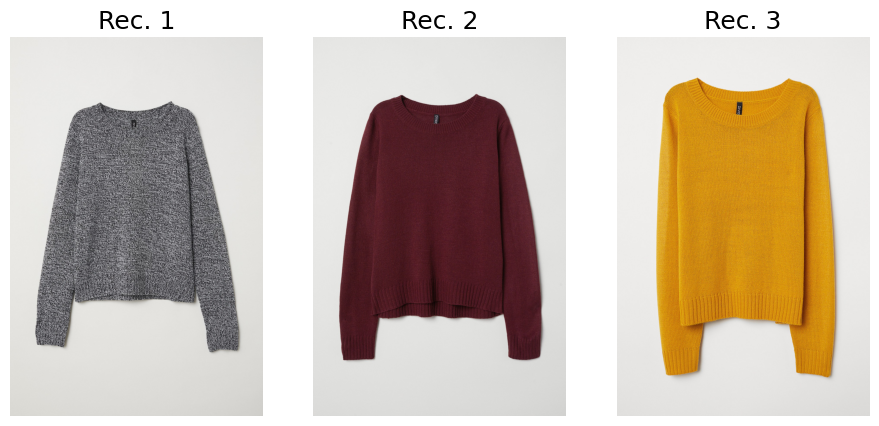

In [53]:
import os
import cv2
import matplotlib.pyplot as plt

BASE = "images/"

# Assuming recommendations is a DataFrame with item IDs
item_ids = recommendations.iloc[:3]

# Format file paths using os.path.join
file_paths = [os.path.join(BASE, f"0{item}.jpg") for item in item_ids]

# Check and display images
plt.figure(figsize=(15, 5))
for i, file_path in enumerate(file_paths, start=1):
    if os.path.exists(file_path):
        img = cv2.imread(file_path)[:, :, ::-1]
        plt.subplot(1, 4, i)
        plt.title(f'Rec. {i}', size=18)
        plt.axis('off')
        plt.imshow(img)
    else:
        print(f"File not found: {file_path}")

plt.show()

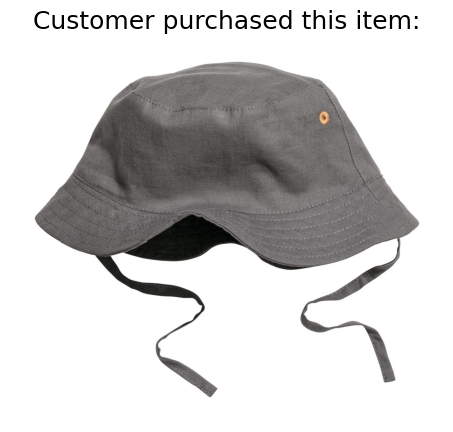

In [93]:
import os
import cv2
import matplotlib.pyplot as plt

BASE_DIR = "images/"
item = 588490001  # Test a random item

# Format file path using os.path.join
image_path = os.path.join(BASE_DIR, f"0{item}.jpg")

# Check if the file exists
if os.path.exists(image_path):
    plt.figure(figsize=(20, 5))
    img = cv2.imread(image_path)[:, :, ::-1]
    plt.title('Customer purchased this item:', size=18)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
else:
    print(f"File not found: {image_path}")

In [95]:
# see results here
recommendations = get_recommendations(item)
print(recommendations)

20332    588490002
16948    572255001
18378    578764001
16946    572254001
16947    572254004
250      205225001
14306    562280001
14307    562280002
22524    598811003
22525    598811005
Name: article_id, dtype: int64


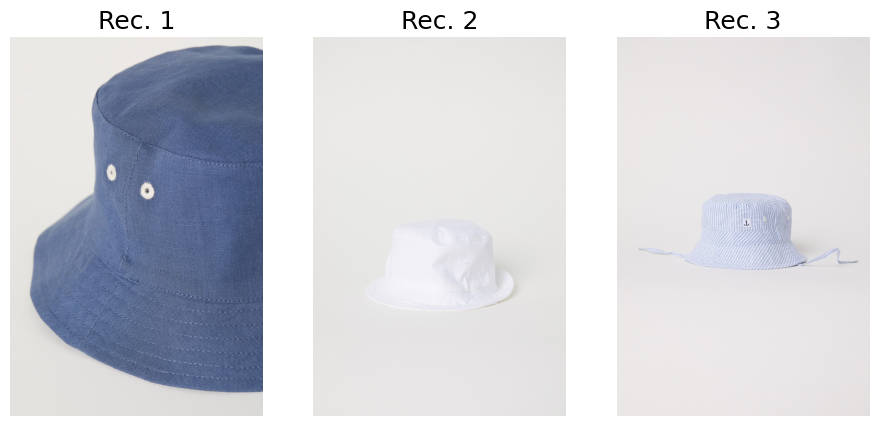

In [97]:
import os
import cv2
import matplotlib.pyplot as plt

BASE = "images/"

# Assuming recommendations is a DataFrame with item IDs
item_ids = recommendations.iloc[:3]

# Format file paths using os.path.join
file_paths = [os.path.join(BASE, f"0{item}.jpg") for item in item_ids]

# Check and display images
plt.figure(figsize=(15, 5))
for i, file_path in enumerate(file_paths, start=1):
    if os.path.exists(file_path):
        img = cv2.imread(file_path)[:, :, ::-1]
        plt.subplot(1, 4, i)
        plt.title(f'Rec. {i}', size=18)
        plt.axis('off')
        plt.imshow(img)
    else:
        print(f"File not found: {file_path}")

plt.show()

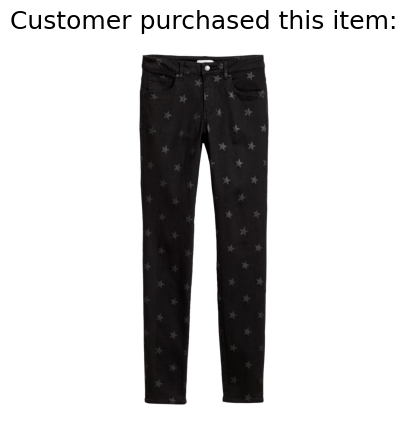

In [107]:
import os
import cv2
import matplotlib.pyplot as plt

BASE_DIR = "images/"
item = 547747001  # Test a random item

# Format file path using os.path.join
image_path = os.path.join(BASE_DIR, f"0{item}.jpg")

# Check if the file exists
if os.path.exists(image_path):
    plt.figure(figsize=(20, 5))
    img = cv2.imread(image_path)[:, :, ::-1]
    plt.title('Customer purchased this item:', size=18)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
else:
    print(f"File not found: {image_path}")

In [109]:
# see results here
recommendations = get_recommendations(item)
print(recommendations)

18760    580345001
9296     532205003
1494     352811001
1495     352811025
1496     352811027
1497     352811033
1498     352811039
2523     411758001
2524     411758003
2525     411758008
Name: article_id, dtype: int64


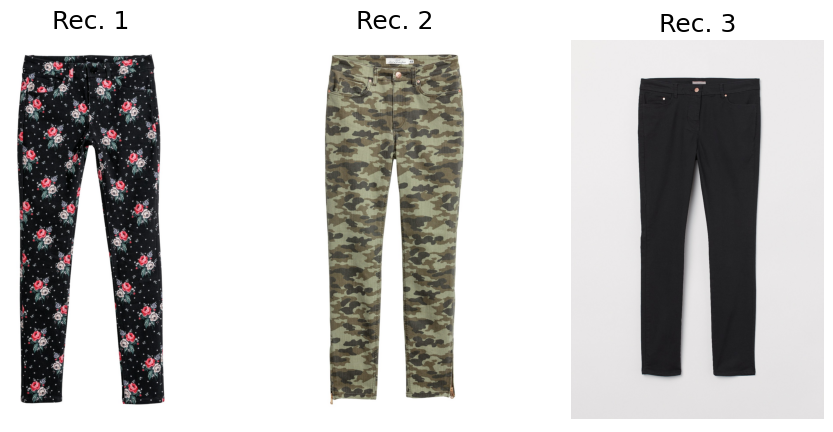

In [111]:
import os
import cv2
import matplotlib.pyplot as plt

BASE = "images/"

# Assuming recommendations is a DataFrame with item IDs
item_ids = recommendations.iloc[:3]

# Format file paths using os.path.join
file_paths = [os.path.join(BASE, f"0{item}.jpg") for item in item_ids]

# Check and display images
plt.figure(figsize=(15, 5))
for i, file_path in enumerate(file_paths, start=1):
    if os.path.exists(file_path):
        img = cv2.imread(file_path)[:, :, ::-1]
        plt.subplot(1, 4, i)
        plt.title(f'Rec. {i}', size=18)
        plt.axis('off')
        plt.imshow(img)
    else:
        print(f"File not found: {file_path}")

plt.show()

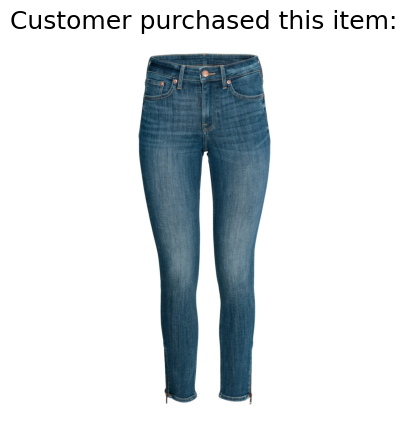

In [143]:
import os
import cv2
import matplotlib.pyplot as plt

BASE_DIR = "images/"
item = 538142004  # Test a random item

# Format file path using os.path.join
image_path = os.path.join(BASE_DIR, f"0{item}.jpg")

# Check if the file exists
if os.path.exists(image_path):
    plt.figure(figsize=(20, 5))
    img = cv2.imread(image_path)[:, :, ::-1]
    plt.title('Customer purchased this item:', size=18)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
else:
    print(f"File not found: {image_path}")

In [145]:
# see results here
recommendations = get_recommendations(item)
print(recommendations)

10044    538142006
10045    538142008
14522    563313003
14523    563313004
14524    563313005
14525    563313006
16217    569189001
16218    569189002
23587    606022001
23588    606022002
Name: article_id, dtype: int64


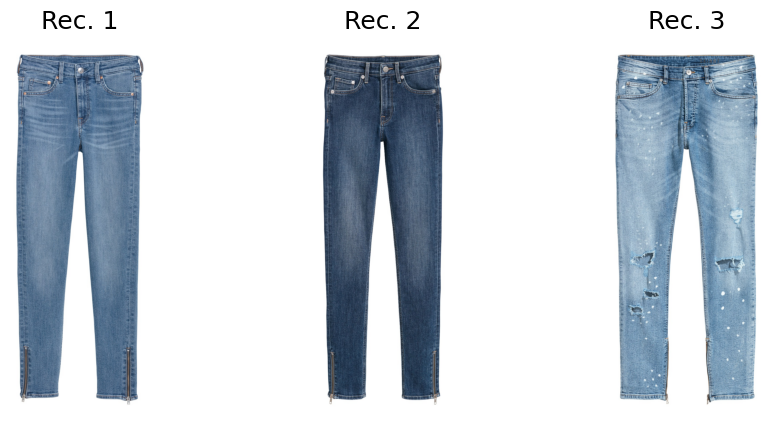

In [147]:
import os
import cv2
import matplotlib.pyplot as plt

BASE = "images/"

# Assuming recommendations is a DataFrame with item IDs
item_ids = recommendations.iloc[:3]

# Format file paths using os.path.join
file_paths = [os.path.join(BASE, f"0{item}.jpg") for item in item_ids]

# Check and display images
plt.figure(figsize=(15, 5))
for i, file_path in enumerate(file_paths, start=1):
    if os.path.exists(file_path):
        img = cv2.imread(file_path)[:, :, ::-1]
        plt.subplot(1, 4, i)
        plt.title(f'Rec. {i}', size=18)
        plt.axis('off')
        plt.imshow(img)
    else:
        print(f"File not found: {file_path}")

plt.show()

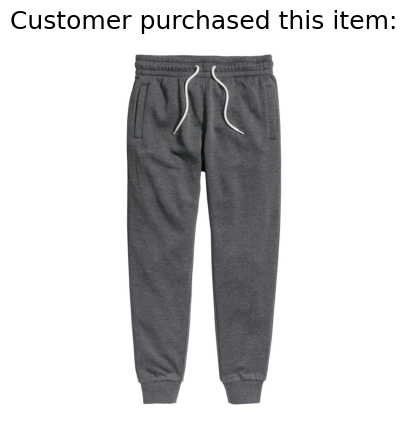

In [226]:
import os
import cv2
import matplotlib.pyplot as plt

BASE_DIR = "images/"
item = 118458003  # Test a random item

# Format file path using os.path.join
image_path = os.path.join(BASE_DIR, f"0{item}.jpg")

# Check if the file exists
if os.path.exists(image_path):
    plt.figure(figsize=(20, 5))
    img = cv2.imread(image_path)[:, :, ::-1]
    plt.title('Customer purchased this item:', size=18)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
else:
    print(f"File not found: {image_path}")

In [228]:
# see results here
recommendations = get_recommendations(item)
print(recommendations)

17       118458004
18       118458028
19       118458029
20       118458034
21       118458038
22       118458039
8296     522167001
11436    547780001
11437    547780002
11438    547780003
Name: article_id, dtype: int64


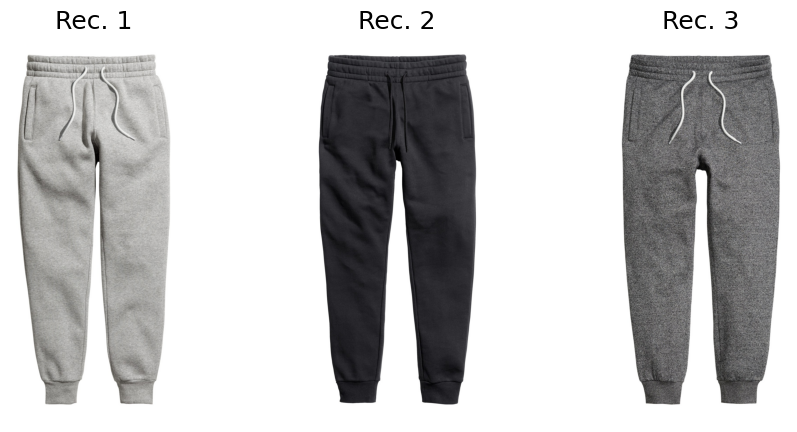

In [230]:
import os
import cv2
import matplotlib.pyplot as plt

BASE = "images/"

# Assuming recommendations is a DataFrame with item IDs
item_ids = recommendations.iloc[:3]

# Format file paths using os.path.join
file_paths = [os.path.join(BASE, f"0{item}.jpg") for item in item_ids]

# Check and display images
plt.figure(figsize=(15, 5))
for i, file_path in enumerate(file_paths, start=1):
    if os.path.exists(file_path):
        img = cv2.imread(file_path)[:, :, ::-1]
        plt.subplot(1, 4, i)
        plt.title(f'Rec. {i}', size=18)
        plt.axis('off')
        plt.imshow(img)
    else:
        print(f"File not found: {file_path}")

plt.show()